# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Apr 16 (Tuesday) 11:00 pm </font>  

<font color="blue"> Ruhani Faiheem Rahman </font>

# I. Overview

This assignment aims to learn one of the major and interesting field of machine learning which is known as reinforcement learning. In this assignment, we will learn the Temporal Difference Learning, SARSA, Q-Learning. For this assignment, we need to study detail about this algorithms and apply in Blackjack game which is a famous card game. We will use Q learning for algorithm to learn the game.

# II. Problems 



## Blackjack

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />

Now, we play Blackjack! 
We have improved version of it from OpenAI Gym [Blackjack-V0](https://gym.openai.com/envs/Blackjack-v0/). Our blackjack has an additional betting option. Here follows the rule description. 


### <font color="red"> Game Introduction and Rules: </font>


Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).

The game starts with each player getting two face up cards and dealer
having one face up and face down card and the player needs to bet an 
amount of money within range of 1 to max bet (10). 
Note: Face up means that you will know what the card is.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
You won't see the dealer's facedown card, just you will know if you have or lost
and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
is drawn.
(It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)

If the player wins, the amount he has bet will be doubled and given back. 
If the player and dealer have the same sum, then its a draw and the player will get
back the money he has bet. 
If the player loses then, the money he bet will be lost. 
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. You are free to change the reward function to make it 
learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 

Regardless of the number of players on the table, each player will be just playing against the 
dealer independently of the other players.

## BlackJack Environment

In [143]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

### Player class definition

Player class defines an object for each BlackJack player with a given *unique* name. It has three attributes, the player's name, current cards in hand, and total balance left to play games.  <code>get_info()</code> is getter method that prints out all three attributes.

In [456]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

Following functions are utilities and definition of card deck to play games and to check the game status. 

In [457]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

### Game Environment

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments. 

These are important member functions to be used by you:
1. add_player: You can add your player object with some initial amount of money

2. step: you need to send the action using this function, actions are hit(1) or stand(0)
        returns {'state': player info and dealer info (_get_obs), 
                 'reward': real-valued reward, 
                 'is_round_done': True/Fasle}
3. _get_obs: returns the state of the env or required information you can use to build your agent. 
             eg: {'player_info':{'player_sum_card': sum of cards, 
                                 'player_card': list of cards, 
                                 'player_total_balance': real-valued number, 
                                 'usable_ace' : True/False}, 
                 'dealer_info': dealer's first card}
4. init_round: will start a new round in the same game.
        returns {'state': player info and dealer info (_get_obs)}
          
5. reset: will reset the whole game and you will being again with the initial balance you had started the player object.
        returns nothing, will just reset the entire game.
          
6. bet_money: you can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10. 
        returns nothing.


In [458]:
class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 100
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
            self.round_bet_info[player_class.player_name] = 0
#            print(player_class.player_name)
#            print(self.players)
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
#        print('Action : ',action)
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
#        print('Ruhani: state : {}, reward : {}, is_round_done : {}'.format(self._get_obs(player_name),reward,done))
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)
               }
    
    def get_valid_bet_amount(self, player_name):
#        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
#        print(self.players)
        if is_winner == 1:
#            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
#            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
#        else:
#            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        for player_name, player_class in self.players.items():
            self.round_bet_info [player_name]= 0


### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random betting and random hit/stick decision making. 

In [460]:
def get_state_from_observation(observation):
#    print(observation)
    player_sum_card = observation['player_info']['player_sum_card']
    dealer_info = observation['dealer_info']
    usable_ace = observation['player_info']['usable_ace']
#    print(observation)
    return '({},{},{})'.format(player_sum_card,dealer_info,usable_ace)

In [461]:
def involve_bet(env, player1, bet_amount):
#    print('Bet Amount : ',bet_amount)
    if len(bet_amount) == 1 and bet_amount[0] == 1:
#        print("You can only bet 1. So betting only 1.")
        random_bet = 1
    else:
        bet_strategy = agent.get_maxQ(observation)
#        print('Bet Strategy : ',bet_strategy)
        if bet_strategy > 1:
            ss = .9
        elif bet_strategy > 0.1:
            ss = .7
        else:
            ss = .1
        random_bet = (int) (bet_amount[-1]*ss)
#        print('Random Bet: ',random_bet)
        if (random_bet == 0):
            random_bet = 1
    
#    print("Random Init Bet: {}".format(random_bet))
    env.bet_money(player1.player_name, random_bet)


In [525]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def play_game(env, player1, agent, number_of_round = 50):

    num_rounds = number_of_round # Payout calculated over num_rounds
    num_samples = 1 # num_rounds simulated over num_samples


    round_played = []
    money_earned = []
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations

    for sample in range(num_samples):

        env.reset()

        for round in range (num_rounds):
            valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
            if valid_bet_flag['is_round_done']:
                print("You are out of money ! Will go to next game !!")
                break
            bet_amount = valid_bet_flag['valid_bet_amount']

            observation = env.init_round(player1.player_name)
    #        print('Observation : {}'.format(observation))
            observation = get_state_from_observation(env._get_obs(player1.player_name))
            # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0

            involve_bet(env, player1, bet_amount)

            is_done = False
            while not is_done:
                action = agent.choose_action(observation)
    #            print('Action : {}'.format(action))

                next_step = env.step(player1.player_name,action)
                next_observation = next_step['state']
                payout = next_step['reward']
                is_done = next_step['is_round_done']
    #            print('Next Observation : {}'.format(env._get_obs(player1.player_name)))
                next_observation = get_state_from_observation(env._get_obs(player1.player_name))
                total_payout += payout
                observation = next_observation

#            average_payouts.append(total_payout/(sample*num_rounds + round+1))
#        round_played.append(round+1)
#        money_earned.append(env.players[player1.player_name].total_balance)
#        print('Round Played This Time : {}'.format(round+1))
    return (sample*num_rounds + round+1), env.players[player1.player_name].total_balance

#    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/num_samples))


In [277]:
env = BlackjackEnv()
player = Player('faiheem')
env.add_player(player)
_r, _m = play_game(env, player, agent)
print(_r, _m)

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random I

In [163]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 10

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see this message, you are the winner.")
    print("Total number of rounds played = {} ".format(_round+1))        


--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 7, 'player_card': [3, 4], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 9}}
Random Init Bet: 9
Action taken: 1
State after 1st action: {'state': {'player_info': {'player_sum_card': 9, 'player_card': [3, 4, 2], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 9}, 'reward': 0, 'is_round_done': False}
Action taken: 1
State after nth action: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [3, 4, 2, 6], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 9}, 'reward': 0, 'is_round_done': False}
Action taken: 0
player winner
State after nth action: {'state': {'player_info': {'player_sum_ca

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Decide your function approximator.
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

### Review of SARSA and Q-Learning

Reinforcement learning is a kind of machine learning where an agent is learning though its action. It is the most effective way of learning if we have no idea about the system. Agent gets positive reward when it does some improvement over the course. And it gets negetive rewards otherwise.

If the model learning is very huge then it is difficult to learn everything all at a time. It also takes a huge memory. For this reason we can use partial learning where agent only knows its next state. It has no idea about the overall model.

SARSA and Q-Learning are these type of learning model which is based on Temporal Deference Learning.

Q-Learning is an off-policy algorithm for TD learning. This algorithm can approximated cloaser to the action  value function. It learns the optimal policy from the actions taken by itself.

SARSA is an on-policy algorithm for TD-Learning. The major difference between Q learning and SARSA, the maximum reward for the next state is not necessarily used for updating Q values. A new action and reward is selected using the same policy. 

In both learning algorithm the next action is choosen by the greedy approach. We can also select the random action in accordance with the value of apsilion. When it is equal to 1, we can chose the action randomly.


### Choice of TD learning and Reason

For this particular blackjack problem we choose Q-learning over SARSA. Because Q-learning can deal with the future events more than SARSA. In Q learning we update the estimate from the maximum estimate of the possible next actions While SARASA updates the estimate based on the same action. There are some specific reason to chose Q learning over SARASA
    - Q learning derectly learns optimal policy, on the other hand SARSA learns the nearest optimal exploring the all path.
    - SARSA will go over all the possible solutions and make the learning process lengthy, while Q learing ingore those unnecessary paths and derectly approach to the main goal.



### Choice of Function Approximation and Reason

Here we are taking concern over the some features like player sum, dealer hand along with usable ace. So, this can be considered as a 3 features. Taking it together and finding the more sophisticated output is required. After that we explored both option depending in this 3 tuples hit and skip.

If we did not explore these different 3 tuple while learning, then our model can not efficiently learn. We also chose the action based on elipson greedy approach. 

### Implementation of the selected approach (RLAgent)

In [459]:
import random

class RLAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        self.valid_actions = list(range(self.env.action_space.n))

        self.Q = dict()          
        self.epsilon = epsilon   
        self.alpha = alpha      
        self.gamma = gamma      
        
        self.num_episodes_to_train = num_episodes_to_train
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) 
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train)
        
        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):

        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):

        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):

        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):

        self.create_Q_if_new_observation(observation)

        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        
#        print('{},{},{},{}'.format(observation, action, reward, next_observation))

        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

### Explanation of the codes

#### Learn:

To learn the model we use the equation

Q[s,a] = Q[s,a] + alpha * (reward + gamma * max(Q[s1,a1]) - Q[s,a])

That way our q learing learns the action over the course

#### Action Choice:

We use epsilon greedy here. if random action is greater than the epsilon then we chose max of Q value for our learning. other wise we choose the action randomly.

#### update parameter:

Over the time, we update our epsilon. For the first 30% iteration we decrease epsilon slowly. After than we decrese highly. Then for the last 30% we again decrese slowly and eventually get the value to zero. That means every action is choosen using the epsilon greedy


## RLAgent for Blackjack

Referencing the RLAgent in the lecture note, make your own agent class for the game. 

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Reports the selected parameters

For this Q learning approach to the Blackjack game, we have 3 parameters. epsilon, gamma, alpha

##### Epsilon
Epsilon is the exploration factor of the model. Higher value of epsilon suggests that choosing the action based on random choice. Lower value of epsilon suggests to take the action based on learned model. So, in general first the value should be high. Because at first we have no idea about the model. Over the time when the model is started learning, this value should decrease to choose action from learned model. 

##### Alpha
Alpha is the learning rate of the model. This value determines how the model hould learn. 0 means model will not learn anything. So, this parameter will help us to determine how fast or slow we will learn in oir model. LOwer value determines slow learning.

##### Gamma
This is known as the discount factor. Is reflects the future reward. The value of zero determines that it has short sighted. That means it has no interest over the long term reward. For higher value closer to 1 means long sighted. Here we will find a optimal value for discount factor.

Training Model : epsilon : 0.8, alpha : 0.3, gamma : 1.0
Average payout after 1000 rounds after training for 200 episodes is -249.02
Training Model : epsilon : 0.5, alpha : 0.9, gamma : 0.7
Average payout after 1000 rounds after training for 400 episodes is -224.88
Training Model : epsilon : 0.6, alpha : 0.9, gamma : 1.0
Average payout after 1000 rounds after training for 600 episodes is -175.64
Training Model : epsilon : 0.8, alpha : 0.8, gamma : 0.4
Average payout after 1000 rounds after training for 800 episodes is -190.3
Training Model : epsilon : 0.3, alpha : 0.9, gamma : 0.4
Average payout after 1000 rounds after training for 1000 episodes is -284.94
Training Model : epsilon : 0.7, alpha : 0.1, gamma : 0.8
Average payout after 1000 rounds after training for 1200 episodes is -149.62
Training Model : epsilon : 0.3, alpha : 0.7, gamma : 0.8
Average payout after 1000 rounds after training for 1400 episodes is -208.58
Training Model : epsilon : 0.5, alpha : 0.6, gamma : 1.0
Average pa

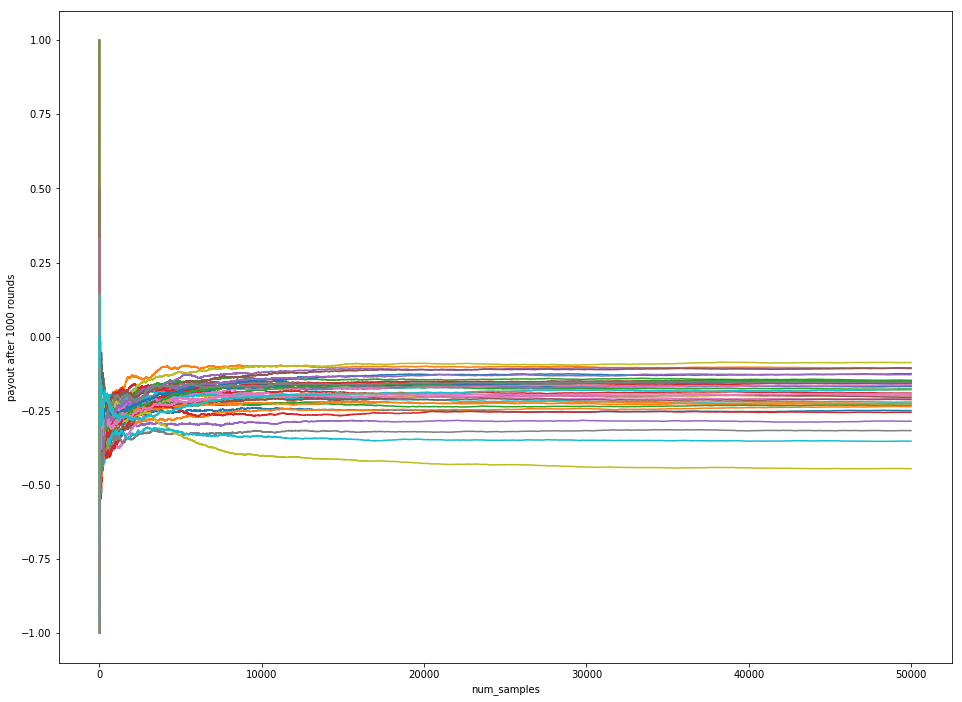

Average payout after 1000 rounds is -195.31775704245902


In [464]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = BlackjackEnv()
player1 = Player('ruhani')
env.add_player(player1)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(200, 8000, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                  
round_played = []
money_earned = []
epsilons = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
gammas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kount = 0
ep_len = epsilons.__len__()
# Run simulations over different values of 'num_episodes_to_train' to find the one with best payout
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
    
#    agent = RLAgent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)
    index_1 = np.random.randint(0, ep_len)
    index_2 = np.random.randint(0, ep_len)
    index_3 = np.random.randint(0, ep_len)
    agent = RLAgent(env=env, epsilon=epsilons[index_1], alpha=alphas[index_2], gamma=gammas[index_3], num_episodes_to_train=num_episodes_value)
    
    

    for sample in range(num_samples):
        
        env.reset()

        for round in range (num_rounds):
            """
            valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
            if valid_bet_flag['is_round_done']:
#                print("You are out of money ! Will go to next game !!")
                break
            bet_amount = valid_bet_flag['valid_bet_amount']
            """

            observation = env.init_round(player1.player_name)
    #        print('Observation : {}'.format(observation))
            observation = get_state_from_observation(env._get_obs(player1.player_name))
            # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0

#            involve_bet(env, player1, bet_amount)

            is_done = False
            while not is_done:
                action = agent.choose_action(observation)
    #            print('Action : {}'.format(action))

                next_step = env.step(player1.player_name,action)
                next_observation = next_step['state']
                payout = next_step['reward']
                is_done = next_step['is_round_done']
    #            print('Next Observation : {}'.format(env._get_obs(player1.player_name)))
                next_observation = get_state_from_observation(env._get_obs(player1.player_name))
                agent.learn(observation, action, payout, next_observation)
                total_payout += payout
                observation = next_observation

            average_payouts.append(total_payout/(sample*num_rounds + round+1))
#            average_payouts.append(total_payout/(num_samples))
        round_played.append(round+1)
        money_earned.append(env.players[player1.player_name].total_balance)
#        print('Round Played This Time : {}'.format(round+1))
    plt.plot(average_payouts)
    print("Training Model : epsilon : {}, alpha : {}, gamma : {}".format(epsilons[index_1],alphas[index_2],gammas[index_3]))
    kount += 1 
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/num_samples))
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

Fig 1

### Experimental outputs that show the choice of parameters. How do you choose them?

We tested our RLAgent using different parameters. The average payout over 1000 games, we find that 
'Training Model : epsilon : 0.3, alpha : 0.2, gamma : 0.1'. 

Average payout after 1000 rounds episodes is -86.9, which is the lowest of all 40 random selection of parameters.

Average payout for 1000 games is lowest for these parameter value. We tested over 20 different combination of the 3 parameters between value 0.1 to 1.0. 

So we are using 
epsilon : 0.3, 
alpha : 0.2, 
gamma : 0.1
for our model.

Training Model : epsilon : 0.3, alpha : 0.2, gamma : 0.1
Average payout after 1000 rounds after training for 3800 episodes is -86.9


### Output plots

### Training the model using selected parameter

In [506]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = BlackjackEnv()
player1 = Player('ruhani')
env.add_player(player1)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(200, 8000, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                  
round_played = []
money_earned = []
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations

agent = RLAgent(env=env, epsilon=0.3, alpha=0.1, gamma=0.2, num_episodes_to_train=num_episodes_value)


epsilon_values = []

for sample in range(num_samples):

    env.reset()
    for round in range (num_rounds):
        """
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
#                print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        """

        observation = env.init_round(player1.player_name)
#        print('Observation : {}'.format(observation))
        observation = get_state_from_observation(env._get_obs(player1.player_name))
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0

#            involve_bet(env, player1, bet_amount)

        is_done = False
        while not is_done:
            if sample == 0:
                epsilon_values.append(agent.epsilon)
            action = agent.choose_action(observation)
#            print('Action : {}'.format(action))

            next_step = env.step(player1.player_name,action)
            next_observation = next_step['state']
            payout = next_step['reward']
            is_done = next_step['is_round_done']
#            print('Next Observation : {}'.format(env._get_obs(player1.player_name)))
            next_observation = get_state_from_observation(env._get_obs(player1.player_name))
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation

        average_payouts.append(total_payout/(sample*num_rounds + round+1))
#            average_payouts.append(total_payout/(num_samples))
    round_played.append(round+1)
    money_earned.append(env.players[player1.player_name].total_balance)
#        print('Round Played This Time : {}'.format(round+1))
plt.plot(average_payouts)
print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/num_samples))
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

Average payout after 1000 rounds after training for 7800 episodes is -91.2


Average payout after 1000 rounds is -116.52330160110517


Fig 2

In [507]:
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()

Fig 3

### Testing of the Model

In [508]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = BlackjackEnv()
player1 = Player('ruhani')
env.add_player(player1)

num_rounds = 50 # Payout calculated over num_rounds
num_samples = 250 # num_rounds simulated over num_samples


round_played = []
money_earned = []
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
#agent = RLAgent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

for sample in range(num_samples):

    env.reset()

    for round in range (num_rounds):
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
#            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']

        observation = env.init_round(player1.player_name)
#        print('Observation : {}'.format(observation))
        observation = get_state_from_observation(env._get_obs(player1.player_name))
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0

        involve_bet(env, player1, bet_amount)

        is_done = False
        while not is_done:
            action = agent.choose_action(observation)
#            print('Action : {}'.format(action))

            next_step = env.step(player1.player_name,action)
            next_observation = next_step['state']
            payout = next_step['reward']
            is_done = next_step['is_round_done']
#            print('Next Observation : {}'.format(env._get_obs(player1.player_name)))
            next_observation = get_state_from_observation(env._get_obs(player1.player_name))
            total_payout += payout
            observation = next_observation

        average_payouts.append(total_payout/(sample*num_rounds + round+1))
    round_played.append(round+1)
    money_earned.append(env.players[player1.player_name].total_balance)
#    print('Round Played This Time : {}'.format(round+1))

print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/num_samples))


Average payout after 50 rounds after training for 7800 episodes is -3.088


In [509]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221)
plt.plot(round_played)
plt.plot(np.mean(round_played))
plt.ylabel("# of Round Played")

ax1 = fig.add_subplot(222)
plt.plot(money_earned)
plt.ylabel("# Money Earned")

Text(0, 0.5, '# Money Earned')

Fig 4 & 5

In [523]:
_____ = np.array(round_played)
from scipy import stats
print('Statistics of money earned during the testing : {}'.format(stats.describe(_____)))

Statistics of money earned during the testing : DescribeResult(nobs=250, minmax=(5, 50), mean=43.944, variance=161.4426345381526, skewness=-1.8831003384456146, kurtosis=2.0145912920567914)


In [516]:
print('Average round played in 250 games : {}'.format(np.mean(round_played)))
print('Standerd Deviation round played in 250 games : {}'.format(np.std(round_played)))

Average round played in 250 games : 43.944
Standerd Deviation round played in 250 games : 12.680570334176613


In [522]:
_____ = np.array(money_earned)
from scipy import stats
print('Statistics of money earned during the testing : {}'.format(stats.describe(_____)))

Statistics of money earned during the testing : DescribeResult(nobs=250, minmax=(0, 103), mean=35.136, variance=682.2143614457832, skewness=0.1564113728670235, kurtosis=-0.7182366091525028)


In [524]:
print('Average money earned in 250 games : {}'.format(np.mean(money_earned)))
print('Standerd Deviation money earned in 250 games : {}'.format(np.std(money_earned)))

Average money earned in 250 games : 35.136
Standerd Deviation money earned in 250 games : 26.066942743636048


### Reading and analysis of learning results and plots

##### Fig 1:

This figure shows the average payout over the 50 * 1000 iterations each. Total 20 different parameters used and checks. We can see that average payout is approximately -0.33 which means that dealer owns most of the cases. On average, for each 3 match played 2 match winned by the dealer. And player wins only 1 match. Our player's goal is to bet as much as possible at the 1 match when he is winning.  

##### Fig 2 :

We use here our selected parameter and see the result is almost same for the previous result observed.

##### Fig 3:

This figure shows the exploring rate over the time. We take 50 * 1000 rounds to learn our model. And over the time spailon decreases 0.3 to 0.2825. Which is good for our learning.

##### Fig 4:

This figure shows the number of round played in each of 250 games. Here most of the games played full 50 rounds. Which indicated a good learning model and betting strategy.

- Average round played = 5.136
- Minimum = 5
- Maximum = 50
- Standard Deviation = 12.68

##### Fig 5:

This figure shows the number of money earned in each of 250 games. Here most of the games played full 50 rounds. So, earned money is quite reasonable. Which indicated a good learning model and betting strategy.

- Initial Amount for each player = 10 
- Average money earned = 43.944
- Minimum = 0
- Maximum = 103
- Standard Deviation = 26.07


## Participation in the Tournament

This model can perform in the tournament and hopefully done well.

# V. Conclusions

First we have to find out the optimal parameter for the model learning. And next we have to determine which state should we choose. After trial and error we determined that 3 tuples to use as state for our model. That is the challenging task for me. I also implement a demo of Qualification round and Tournament round to see how the learned model performs in a tournament. Most if the cases player survives 50 rounds. 

# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- In qualification game, individual will play against a dealer for one game for 50 round. 
  - Highly ranked (by the profit) and non-broke players will proceed to the tournament.
  - max. 32 players will be cut for main tournament.
- In tournament, 4 players will be play in each round.
  - In a table game, the game lasts until two players broke
  - In final, the game will ends in 50 rounds and winner will be the one with highest balance. 

### Qualification Round

In [278]:
env = BlackjackEnv()
player = Player('rahman')
env.add_player(player)
_r, _m = play_game(env, player, agent)
print(_r, _m)

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Rand

In [280]:
env = BlackjackEnv()
player_list = {}
n = 50
_r = []
_m = []
for i in range (n):
    env = BlackjackEnv()
    player1 = Player(i)
    env.add_player(player1)
    __r, __m = play_game(env, player1, agent)
    print(__r, __m)
    _r.append(__r)
    _m.append(__m)
print(_r)
print(_m)

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
R

Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
50 7
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the

Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
You are out of money ! Will go to next game !!
37 0
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get

You are out of money ! Will go to next game !!
16 0
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 

Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 

Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
50 5
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money,

Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
You are out of money ! Will go to next game !!
21 0
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4,

Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random I

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try n

Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
50 9
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player 

Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :

Text(0, 0.5, '# Money Earned')

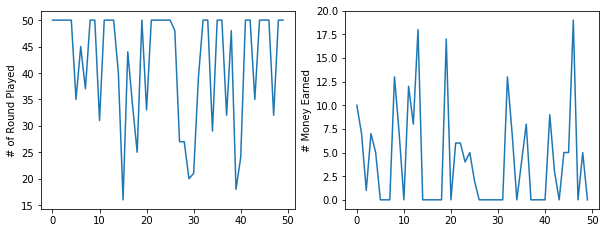

In [281]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221)
plt.plot(_r)
plt.ylabel("# of Round Played")

ax1 = fig.add_subplot(222)
plt.plot(_m)
plt.ylabel("# Money Earned")

In [328]:
env = BlackjackEnv()
player_list = {}
n = 50
_r = []
_m = []
stat_r = dict()
stat_m = dict()

env = BlackjackEnv()
for i in range (n):
    player = Player(i)
    player_list[i] = player
    env.add_player(player)

for player in player_list.keys():
    __r, __m = play_game(env, player_list[player], agent)
    stat_r[player_list[player].player_name] = __r
    stat_m[player_list[player].player_name] = __m
    print(__r, __m)
#_r.append(__r)
#_m.append(__m)
#print(_r)
#print(_m)

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount : 

Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
50 14
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6

player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Ra

Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
50 10
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount 

Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 

Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random 

Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init

Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the mon

Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
You are out of money ! Will go to next game !!
37 0
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6,

player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1

Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0

Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 

player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amoun

In [300]:
type(stat)

dict

In [268]:
for player in player_list.keys():
    print(player_list[player].player_name)
__r, __m = play_game(env, player_list[0], agent)
print(__r,__m)
print('BalChal')
__r, __m = play_game(env, player_list[1], agent)
print(__r,__m)
print('BalChal')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back th

In [314]:
import operator
sorted_x = sorted(stat_r.items(), key=operator.itemgetter(1))

In [322]:
stat_r

{1: 44,
 2: 50,
 3: 26,
 4: 22,
 5: 50,
 6: 50,
 7: 43,
 8: 50,
 9: 50,
 10: 29,
 11: 50,
 12: 50,
 13: 33,
 14: 43,
 15: 36,
 16: 50,
 17: 40,
 18: 24,
 19: 50,
 20: 50,
 21: 50,
 22: 50,
 23: 21,
 24: 50,
 25: 13,
 26: 50,
 27: 18,
 28: 50,
 29: 25,
 30: 50,
 31: 43,
 32: 43,
 33: 50,
 34: 50,
 35: 50,
 36: 23,
 37: 50,
 38: 50,
 39: 50,
 40: 50,
 41: 50,
 42: 33,
 43: 17,
 44: 47,
 45: 16,
 46: 37,
 47: 50,
 48: 15,
 49: 50}

In [325]:
n = 50
qual = 32
for i in range (sorted_x.__len__()):
    if i <= n - qual:
        sorted[i][0]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [326]:
n = 50
qual = 32
for i in range (sorted_x.__len__()):
    if i <= n - qual:
        del stat_r[sorted_x[i][0]]

In [340]:
import operator
def remove_player(d, n, qual):
    r = dict(d)    
    sorted_x = sorted(r.items(), key=operator.itemgetter(1))
    for i in range (sorted_x.__len__()):
        if i <= n - qual - 1:
            del r[sorted_x[i][0]]
    return r

In [341]:
__d = remove_player(stat_m, 50, 32)

In [343]:
__d

{1: 3,
 3: 14,
 4: 12,
 5: 3,
 6: 7,
 7: 7,
 8: 7,
 10: 12,
 11: 10,
 13: 10,
 20: 7,
 21: 8,
 22: 14,
 24: 1,
 26: 12,
 27: 6,
 28: 6,
 30: 5,
 31: 7,
 35: 2,
 36: 16,
 39: 6,
 40: 0,
 41: 5,
 42: 14,
 43: 7,
 44: 11,
 45: 0,
 46: 9,
 47: 0,
 48: 0,
 49: 8}

### Tounament Round : Top 32

In [347]:
i = __d.__len__()
for i in range(__d.keys())
    env = BlackjackEnv()
    player = Player(i)
    player_list[i] = player
    env.add_player(player)

1
3
4
5
6
7
8
10
11
13
20
21
22
24
26
27
28
30
31
35
36
39
40
41
42
43
44
45
46
47
48
49


In [355]:
teams = {}
teams[0] = list()
teams[0].append(0)
teams[0].append(1)
teams[0].append(2)
teams[0].append(3)
teams.values()

dict_values([[0, 1, 2, 3]])

In [392]:
def game_round(agent, _dict, total_team, table_capacity):
    __final_qualified_team = dict()
    total_round = int (total_team / table_capacity);
    teams = {}
    for team_rounds in range (total_round):
        teams[team_rounds] = list()
    team_rounds = 0
    current_count = 0
    for keys in _dict.keys():
        teams[team_rounds].append(keys)
        current_count += 1
        if current_count == 4:
            current_count = 0
            team_rounds += 1
    print(teams)
    for keys in teams.keys():
        env = BlackjackEnv()
        player_list = {}
        for player_num in range (0,table_capacity):
            print(teams[keys][player_num])
            pl = Player(teams[keys][player_num])
            player_list[player_num] = pl
            env.add_player(pl)
        _stat_r = {}
        _stat_m = {}
        for player in player_list.keys():
            __r, __m = play_game(env, player_list[player], agent)
            _stat_r[player_list[player].player_name] = __r
            _stat_m[player_list[player].player_name] = __m
            print(__r, __m)
            #Most Round will Go to Next Round
        __dd = remove_player(_stat_r, table_capacity, int (table_capacity/2))
        print(__dd) 
        for _keys in __dd.keys():
            __final_qualified_team[_keys] = __dd[_keys]
        print('Ami Tomake',_stat_r, _stat_m)
    print(__final_qualified_team)
    return __final_qualified_team

In [401]:
top_16 = game_round(agent, __d, 32, 4)

{0: [1, 3, 4, 5], 1: [6, 7, 8, 10], 2: [11, 13, 20, 21], 3: [22, 24, 26, 27], 4: [28, 30, 31, 35], 5: [36, 39, 40, 41], 6: [42, 43, 44, 45], 7: [46, 47, 48, 49]}
1
3
4
5
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next r

Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8,

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the 

Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
50 9
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9

player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
You are out of money ! Will go to next game !!
36 0
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the mone

Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7

Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3

Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4

In [402]:
top_16

{3: 50,
 4: 50,
 8: 50,
 10: 50,
 20: 50,
 21: 50,
 24: 50,
 27: 50,
 30: 50,
 35: 50,
 39: 50,
 40: 50,
 42: 50,
 43: 50,
 48: 50,
 49: 50}

In [406]:
top_8 = game_round(agent, top_16, 16, 4)

{0: [3, 4, 8, 10], 1: [20, 21, 24, 27], 2: [30, 35, 39, 40], 3: [42, 43, 48, 49]}
3
4
8
10
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init 

Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player winner
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player winner
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random 

Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 

Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
You are out of money ! Will go to next game !!
27 0
{35: 50, 39: 50}
Ami Tomake {30: 50, 35: 50, 39: 50, 40: 27} {30: 14, 35: 20, 39: 12, 40: 0}
42
43
48
49
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get ba

In [407]:
top_8

{8: 49, 10: 50, 21: 41, 27: 50, 35: 50, 39: 50, 43: 50, 49: 43}

In [408]:
top_4 = game_round(agent, top_8, 8, 4)

{0: [8, 10, 21, 27], 1: [35, 39, 43, 49]}
8
10
21
27
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Am

Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont

In [409]:
top_4

{21: 50, 27: 50, 35: 50, 43: 50}

In [413]:
top_2 = game_round(agent, top_4, 4, 4)

{0: [21, 27, 35, 43]}
21
27
35
43
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amou

player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1]
You can only bet 1. So betting only 1.
Random In

In [414]:
top_2

{21: 50, 35: 50}

In [426]:
def final_round(agent, _dict, total_team, table_capacity):
    __final_qualified_team = dict()
    env = BlackjackEnv()
    player_list = {}
    for keys in _dict.keys():
        pl = Player(keys)
        player_list[keys] = pl
        env.add_player(pl)
    _stat_r = {}
    _stat_m = {}
    for player in player_list.keys():
        __r, __m = play_game(env, player_list[player], agent)
        _stat_r[player_list[player].player_name] = __r
        _stat_m[player_list[player].player_name] = __m
        print(__r, __m)
        #Most Round will Go to Next Round
    __dd = remove_player(_stat_m, 2, 1)
    print('Ami Tomake',_stat_r, _stat_m)
    print(__dd) 
    return __dd

In [427]:
winner = final_round(agent, top_2, 2, 1)

Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Bet Strategy :  0.0
Random Bet:  0
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player winner
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
Draw match
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random Init Bet: 1
player loser, wont get back the money, try next round
Bet Amount :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bet Strategy :  0.0
Random Bet:  1
Random I

In [428]:
winner

{35: 4}

In [429]:
Total_Win_Money = winner[35]
print('Winner : {}'.format(winner.keys()))
print('Total Win Money : {}'.format(winner.values()))

Winner : dict_keys([35])
Total Win Money : dict_values([4])


## References

1. Pradyo., 2019, https://github.com/Pradhyo/blackjack
2. Kendall., G., and Smith., C., 2011, The Evolution of BlackJack Strategies, https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
3. Michael B. Wakin and Christopher J. Rozell, A Markov Chain Analysis of Blackjack Strategy, 2011, http://inside.mines.edu/fs_home/mwakin/papers/mcbj.pdf

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
